In [1]:
from superoscillations import *
import matplotlib.pyplot as plt

In [2]:
freq_to_use = ['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz']

## Load input pulses

In [3]:
pulses = pd.read_excel('pulses.xlsx', dtype=np.float)

timecol = 'time (ps)'

# extract time colum and delet it
times = pulses[timecol].to_numpy()
pulses.drop(columns=[timecol], inplace=True)

so = CTSuperoscillations(pulses[freq_to_use], times)

## Loading transmitted pulse for sample 1: no lactose

In [4]:
pulses = pd.read_excel('transmitted wave nonresonant.xlsx', dtype=np.float)

timecol = 'Time (ps)'

# extract time colum and delet it
assert np.allclose(times, pulses[timecol].to_numpy())

pulses.drop(columns=[timecol], inplace=True)

sample_no_lactose = CTSuperoscillations(pulses[freq_to_use], times)

## Loading transmitted pulse for sample 2: lactose

In [5]:
pulses = pd.read_excel('transmitted wave.xlsx', dtype=np.float)

pulses = pulses[freq_to_use]

sample_lactose = CTSuperoscillations(pulses[:sample_no_lactose.times.size], times)

del pulses

# consistency check
assert all(sample_no_lactose.pulses.columns == sample_lactose.pulses.columns)

In [6]:
def plot_pulses(df):
    """
    Plot pulses saved in DataFrame dt
    """
    for colname in df.columns:        
        
        plt.plot(times, df[colname], label=colname)

    plt.ylabel('electric field')
    plt.xlabel(timecol)
    plt.legend(loc='right')

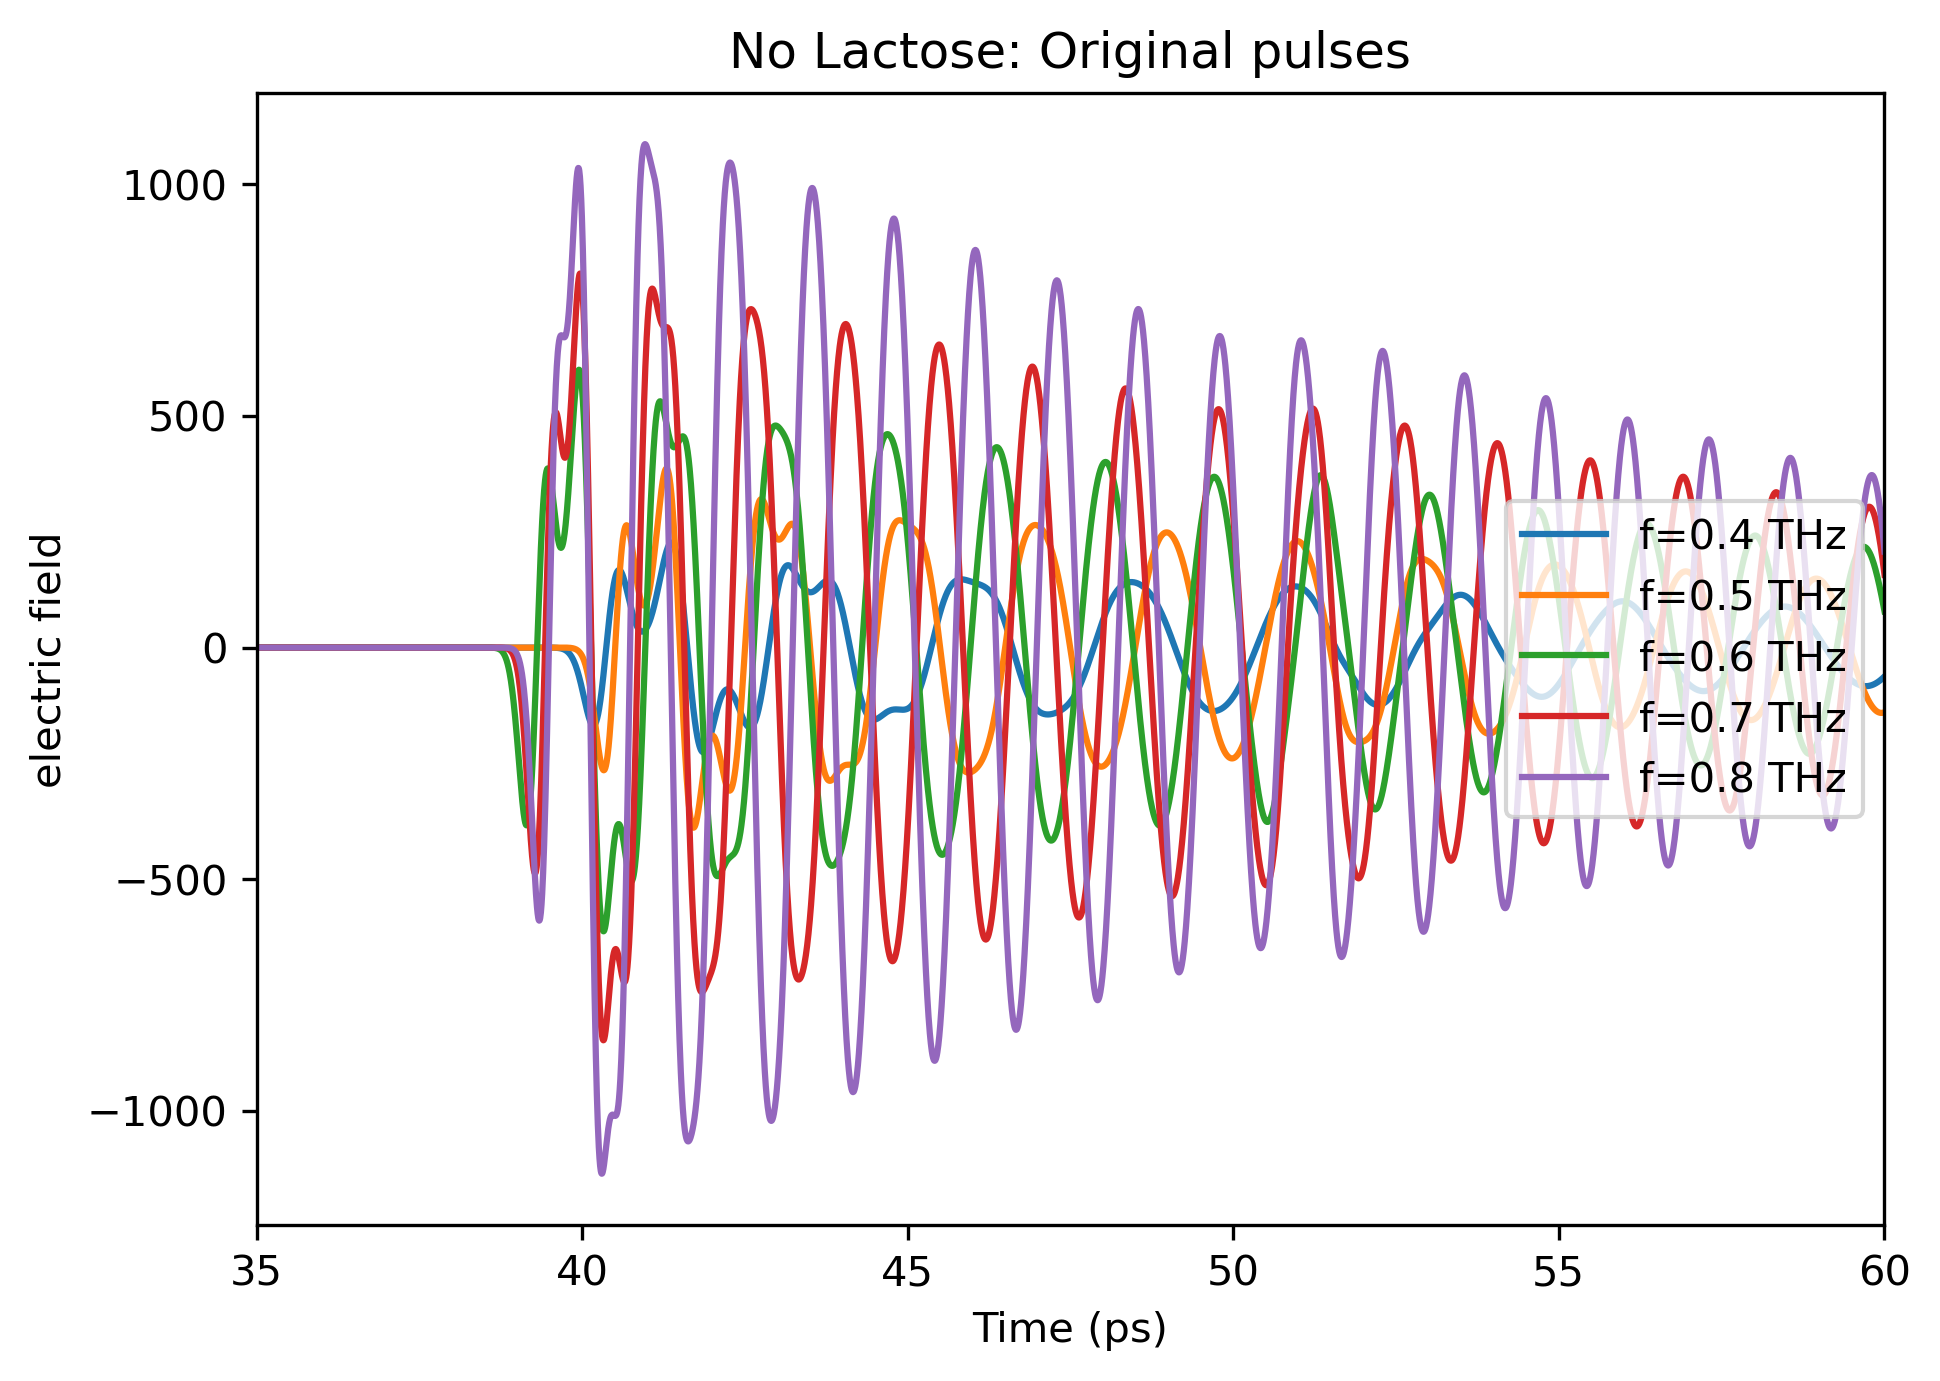

In [7]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 60])
plt.title('No Lactose: Original pulses')
plot_pulses(sample_no_lactose.pulses)
#plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

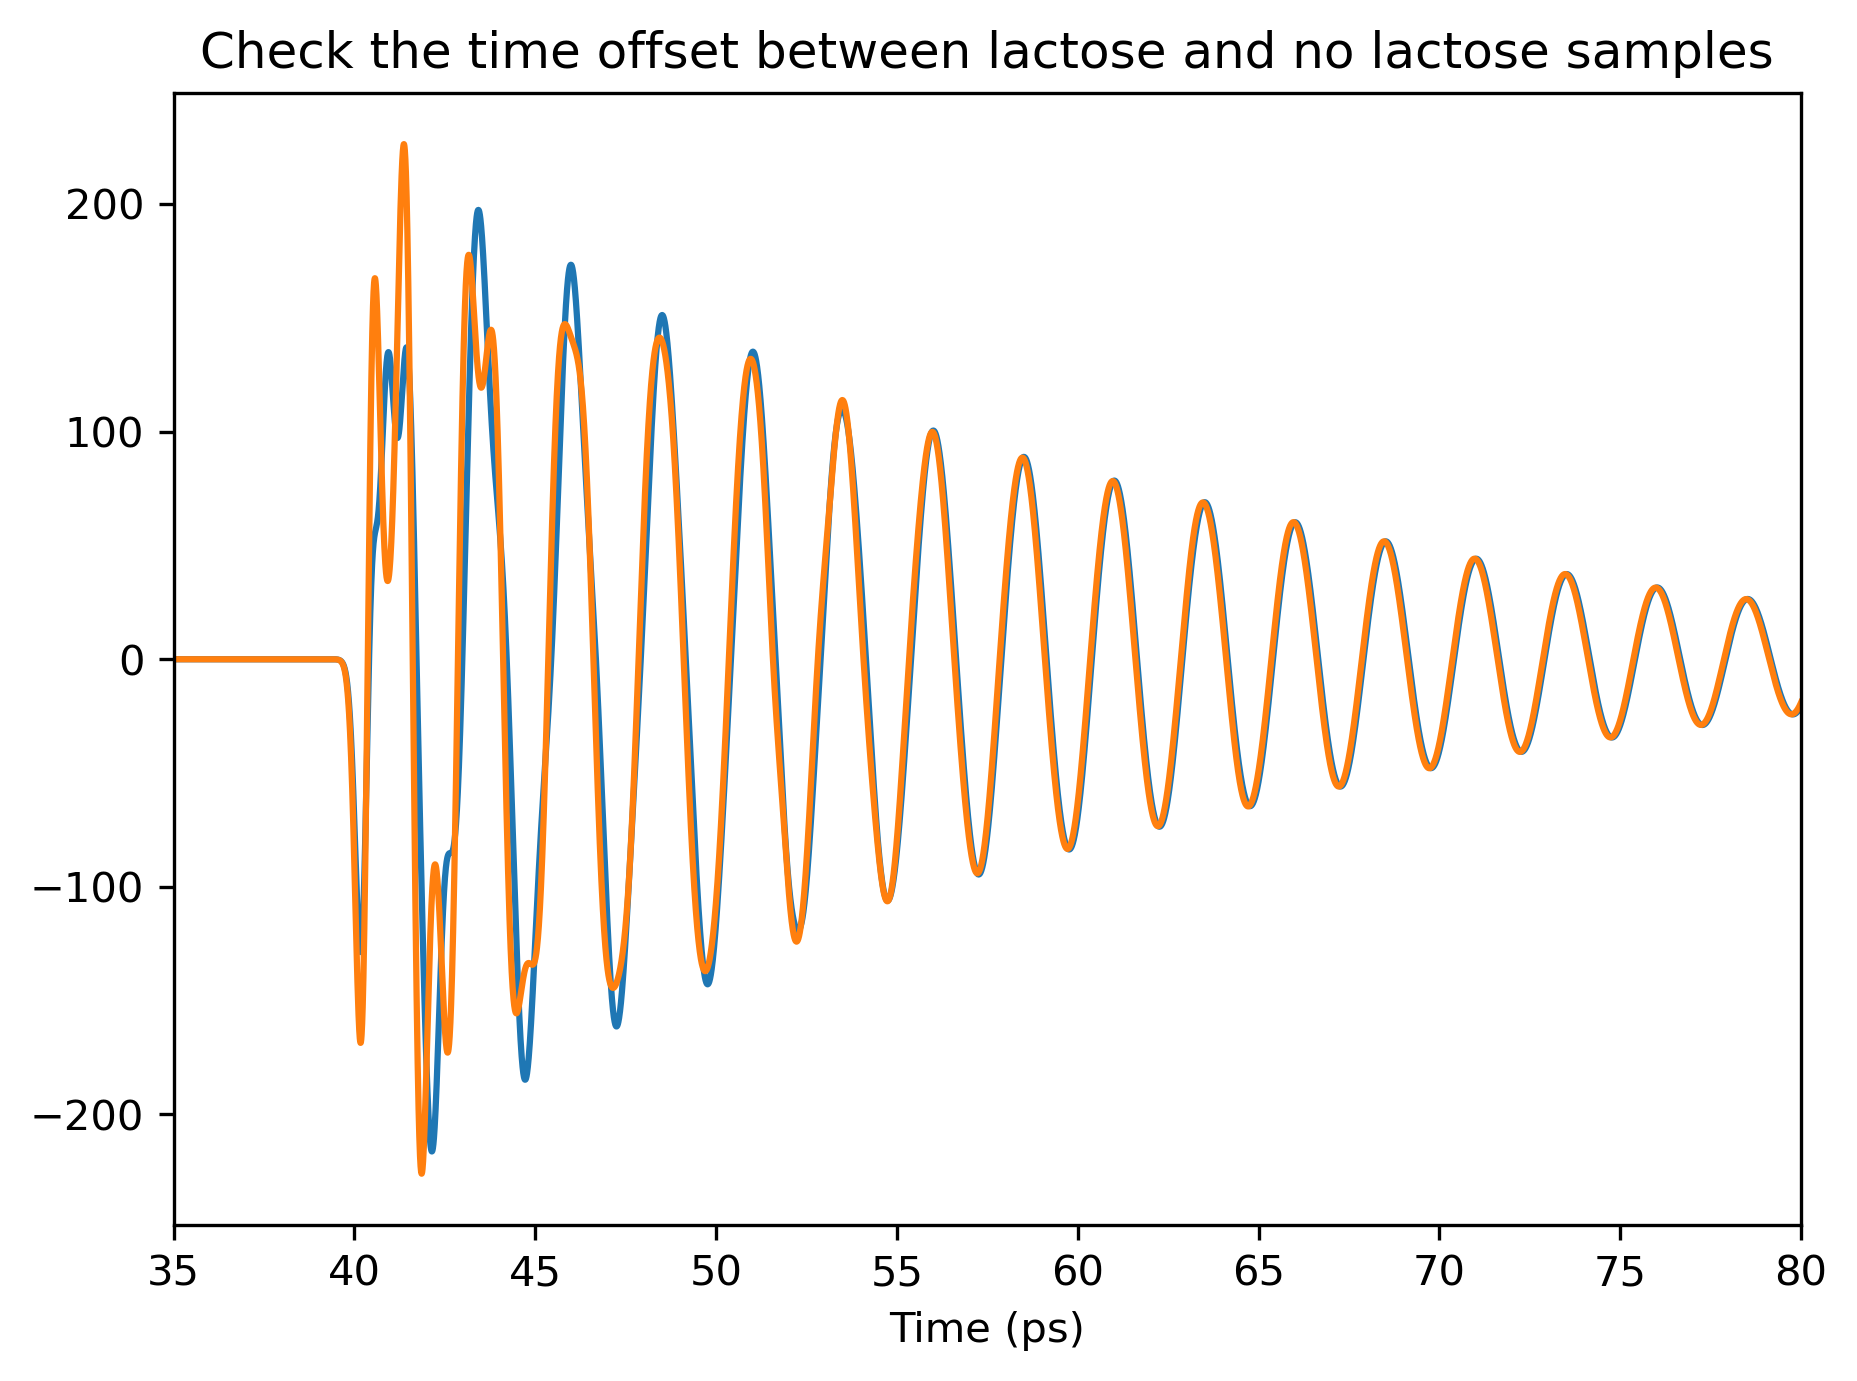

In [8]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 80])
plt.title('Check the time offset between lactose and no lactose samples')

plt.plot(times, sample_lactose.pulses['f=0.4 THz'])

plt.plot(times, sample_no_lactose.pulses['f=0.4 THz'])

plt.xlabel(timecol)

plt.show()

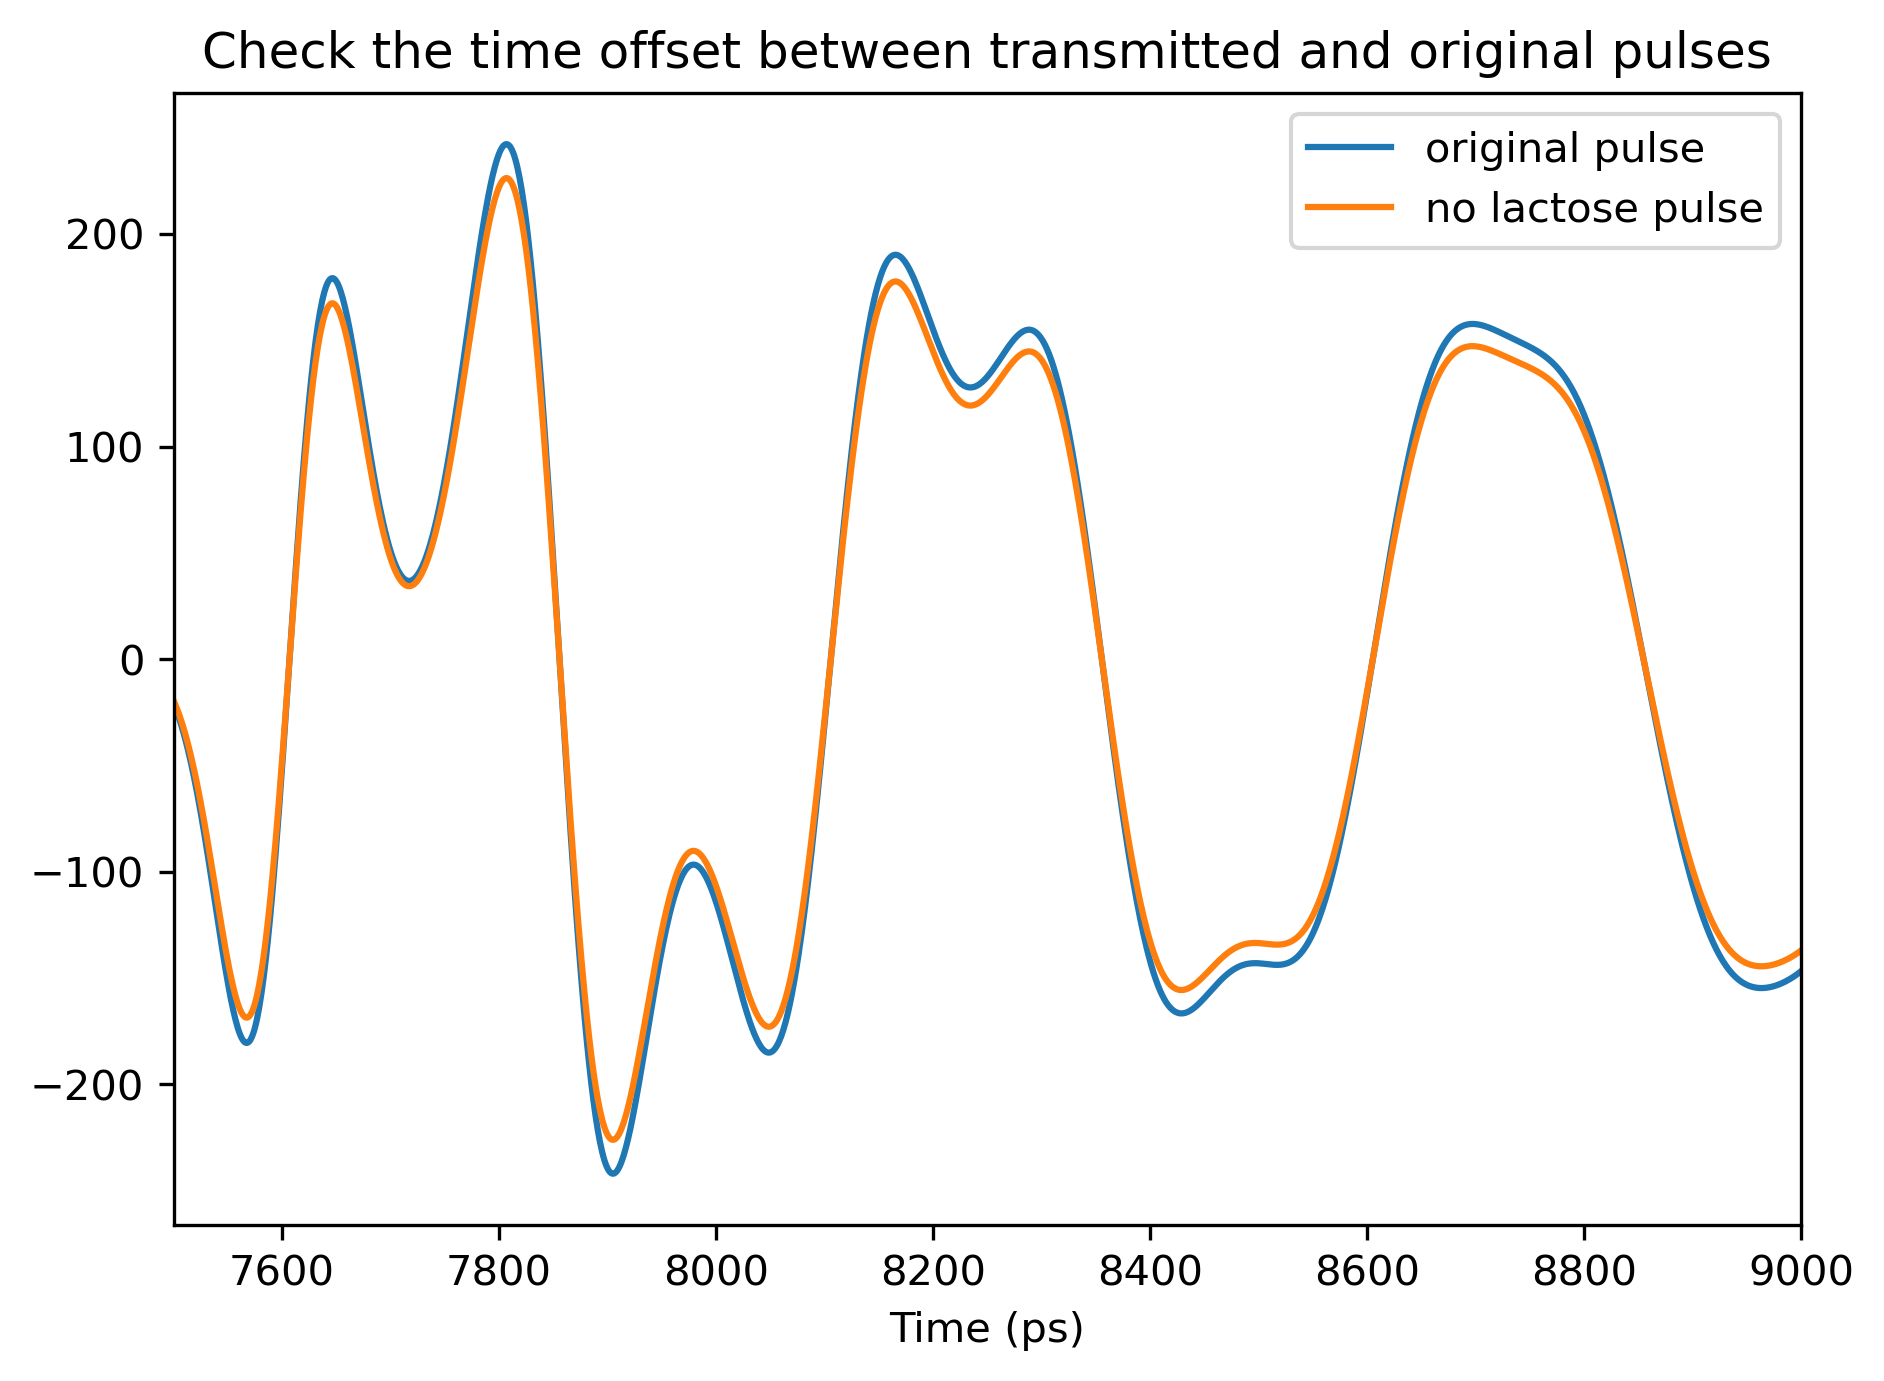

In [9]:
plt.figure(figsize=(7, 5), dpi=300)
#plt.xlim([35, 80])

plt.xlim([7500, 9000])
plt.title('Check the time offset between transmitted and original pulses')

plt.plot(so.pulses['f=0.4 THz'], label='original pulse')

delay = 467

plt.plot(
    np.roll(sample_no_lactose.pulses['f=0.4 THz'], -delay), 
    label='no lactose pulse'
)

plt.xlabel(timecol)
plt.legend()
plt.show()

## Time align the original pulses to synthesize superoscilations

In [10]:
so.time_align_pulses()

# add time delay
so.pulse_shifts = {
    key:val + delay for key, val in so.pulse_shifts.items()
}

# apply the same time alignment to the transmitted pulses
sample_no_lactose.time_align_pulses(so.pulse_shifts)
sample_lactose.time_align_pulses(so.pulse_shifts)

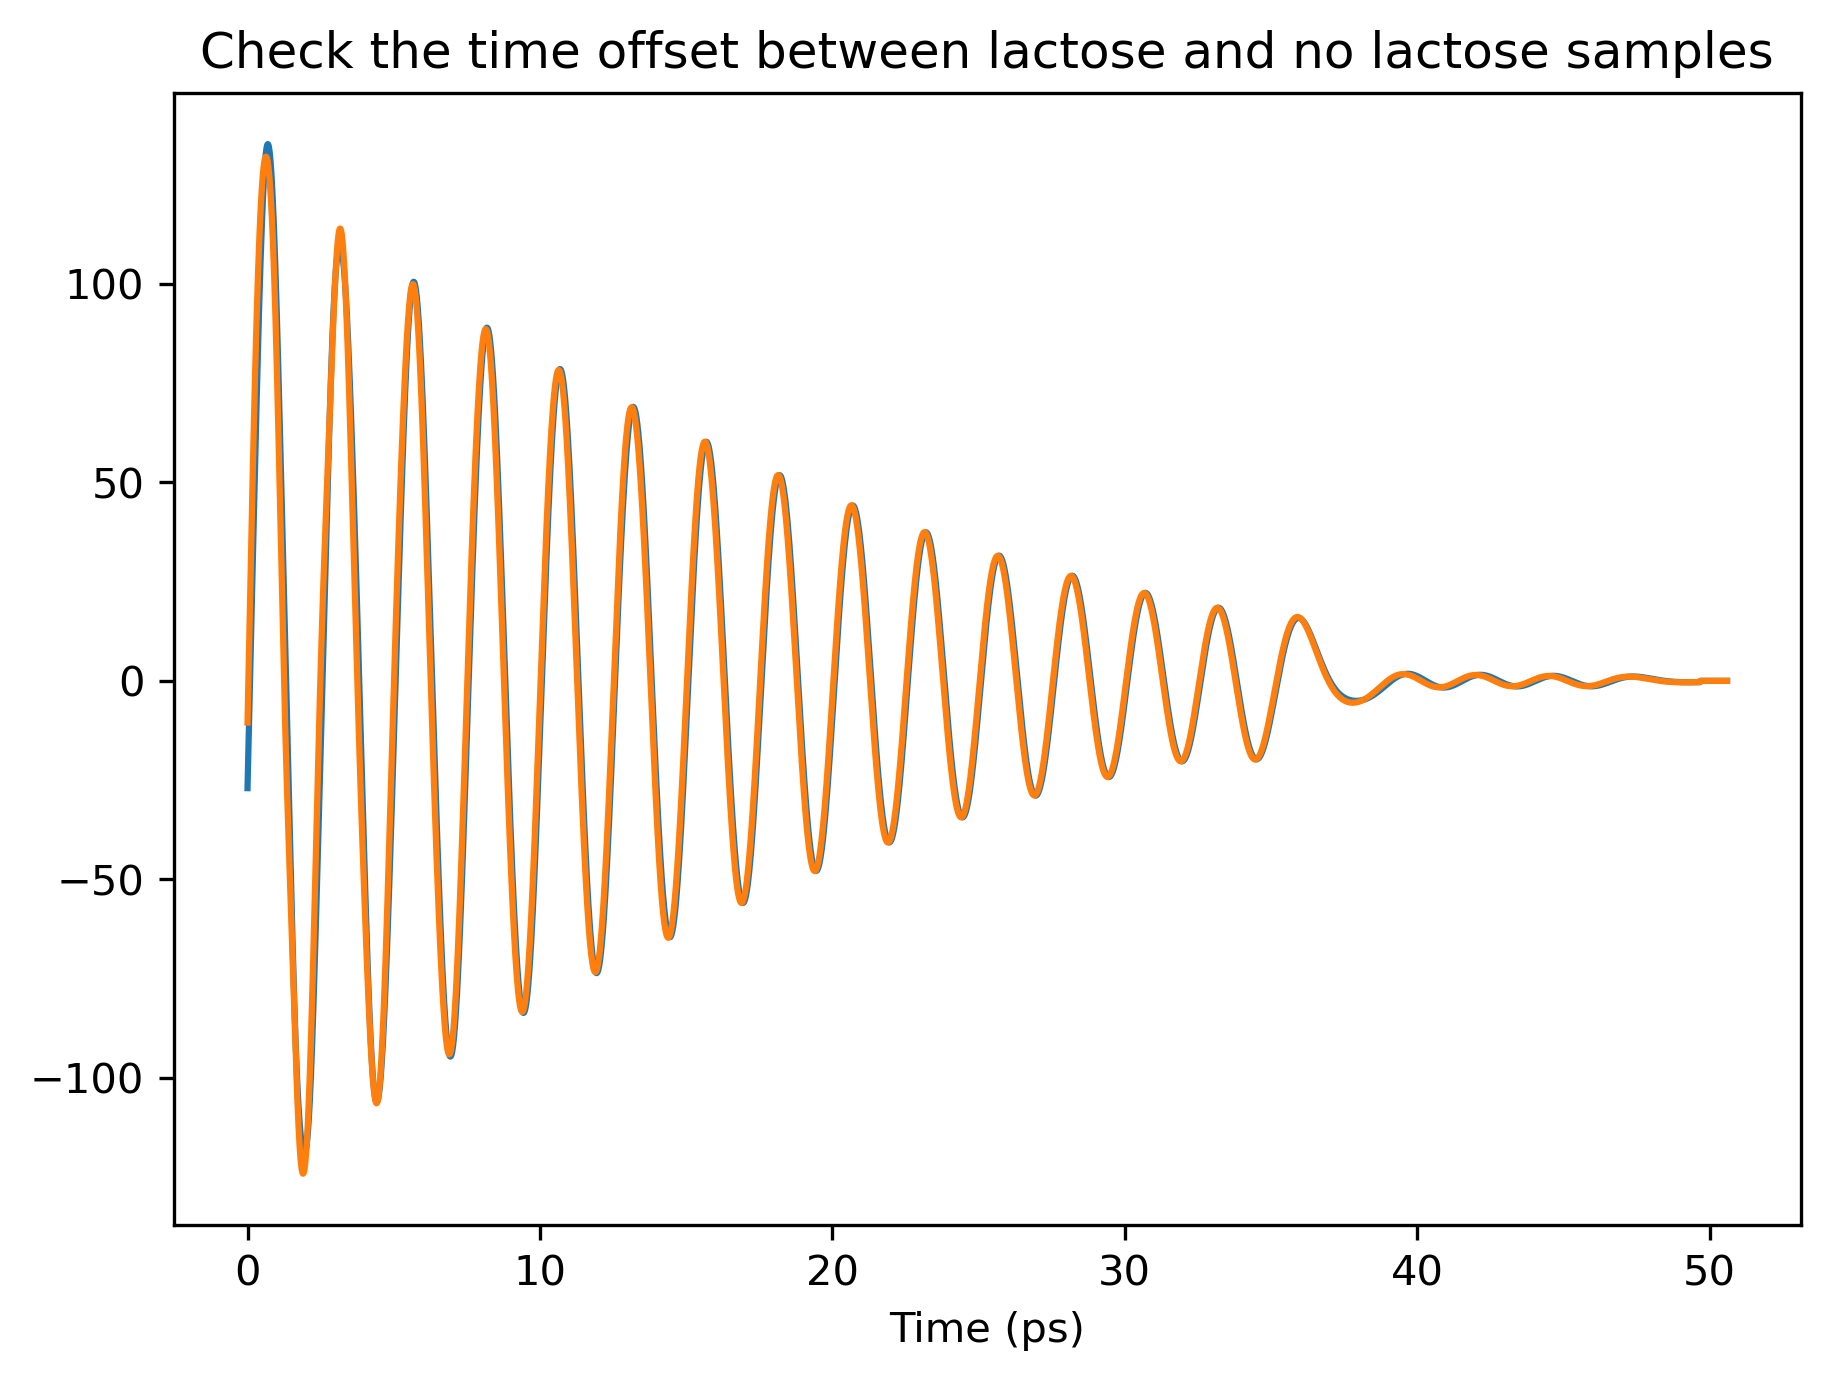

In [11]:
long_observational_time = 40 * so.observational_window


plt.figure(figsize=(7, 5), dpi=300)
plt.title('Check the time offset between lactose and no lactose samples')

plt.plot(
    times[:long_observational_time], 
    sample_lactose.pulses['f=0.4 THz'][:long_observational_time]
)

plt.plot(
    times[:long_observational_time], 
    sample_no_lactose.pulses['f=0.4 THz'][:long_observational_time]
)

#plt.plot(times, so.pulses['f=0.4 THz'])

plt.xlabel(timecol)

plt.show()

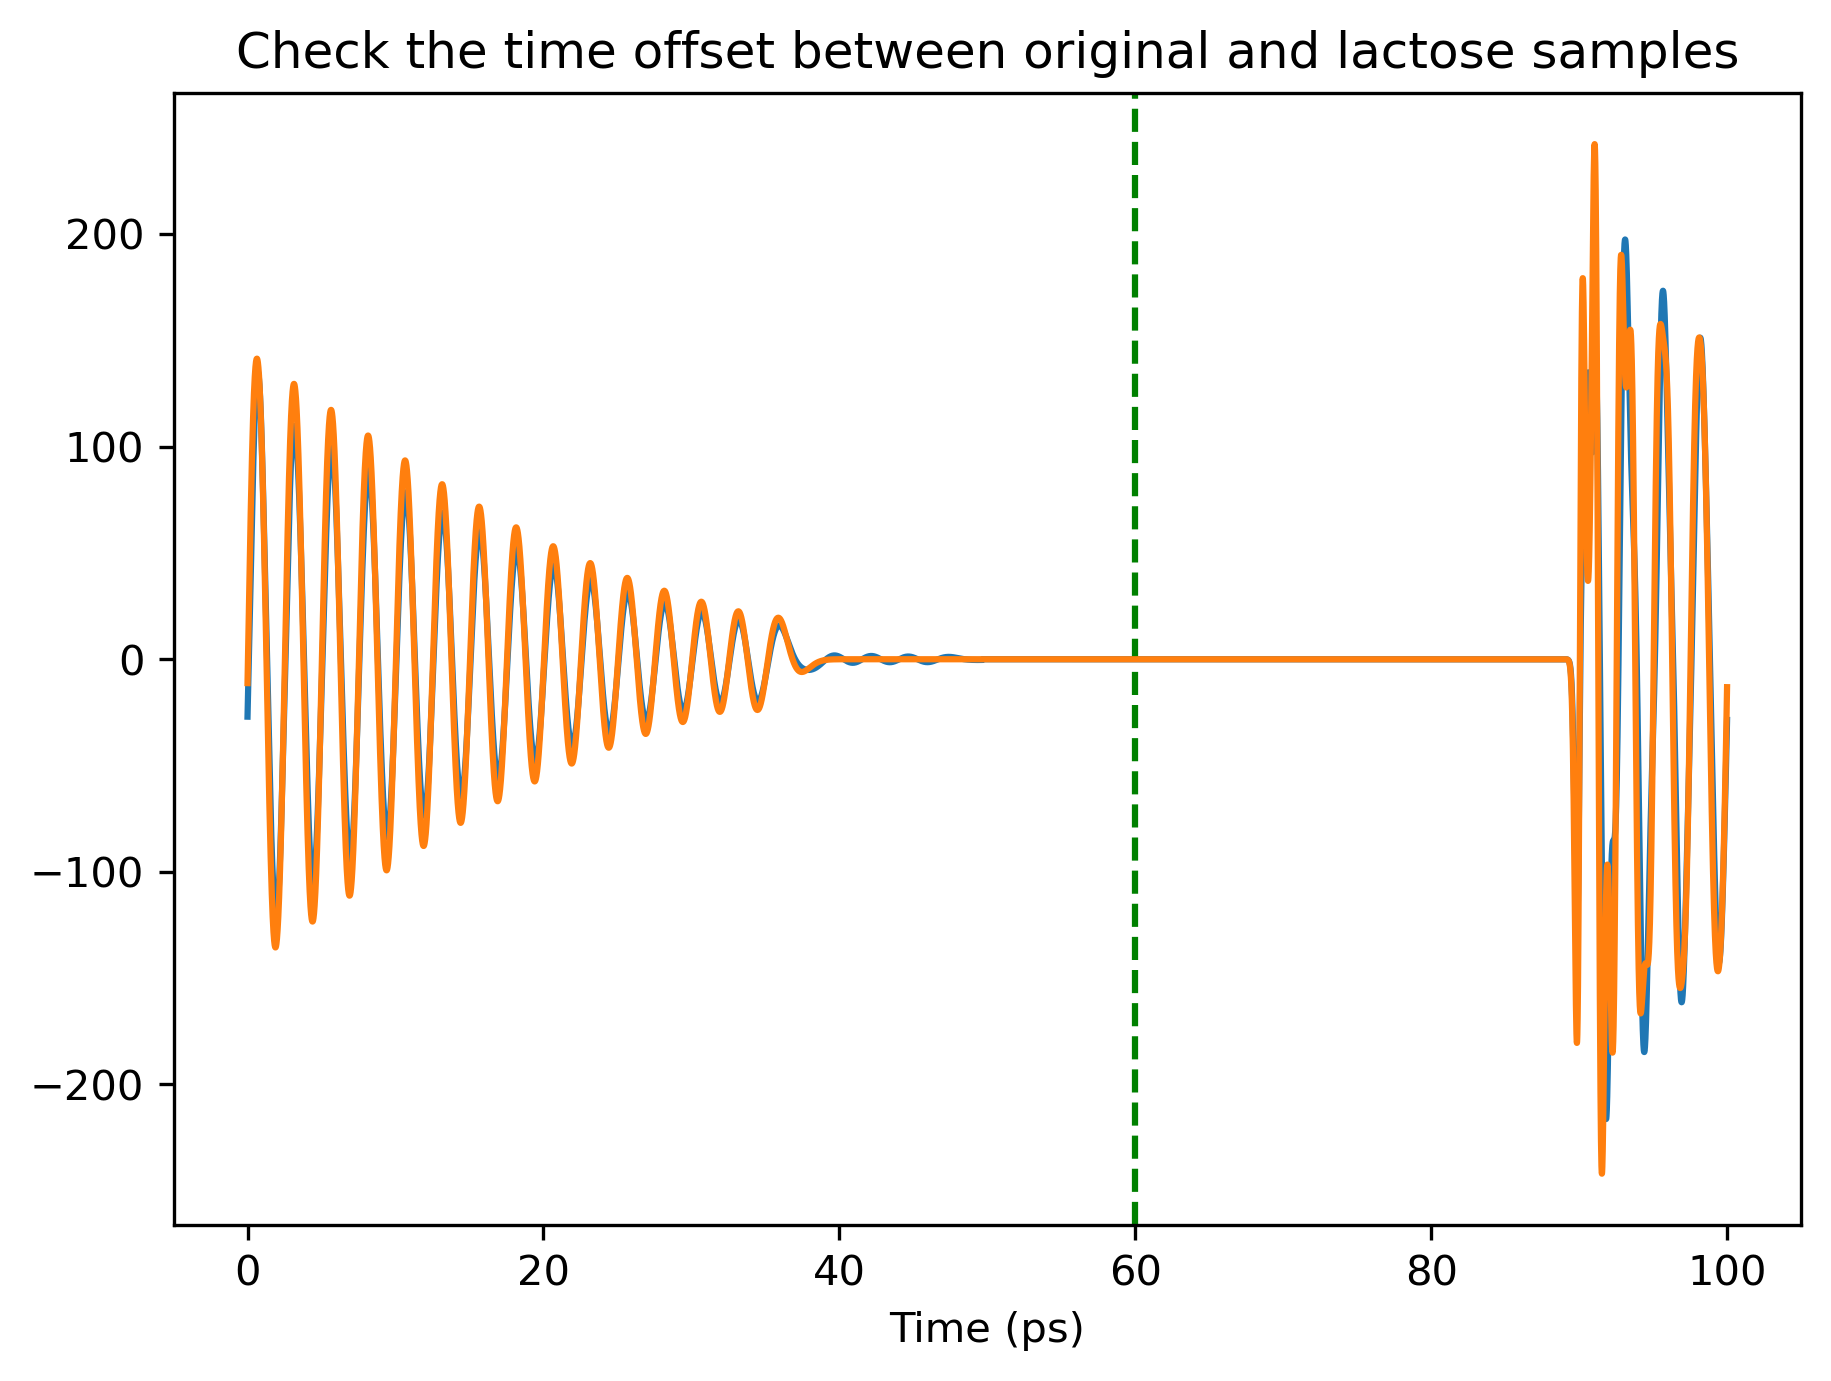

In [12]:
plt.figure(figsize=(7, 5), dpi=300)
#plt.xlim([0, 20])
plt.title('Check the time offset between original and lactose samples')

plt.plot(times, sample_lactose.pulses['f=0.4 THz'])

# when the "junk" strats
pre_pulse_cut_off = int(3 * times.size / 5)
plt.axvline(times[pre_pulse_cut_off], linestyle='--', color='g')

plt.plot(times, so.pulses['f=0.4 THz'])

plt.xlabel(timecol)

plt.show()

## Scanning the values of observational windows

In [13]:
def get_discriminability(field1, field2):
    
    I1 = 0.5 * simps(field1 ** 2)
    I2 = 0.5 * simps(field2 ** 2)
    return simps((field1 - field2)** 2) / (I1 + I2)

def analyze(obs_window):

    obs_window = int(round(obs_window))
    
    # Form the overlap matrix for a given observational window 
    S_observ = get_overlap(
        so.pulses[:obs_window], 
        so.times[:obs_window]
    )
    
    # get superoscilations
    _, vec = eigh(
        S_observ, 
        so.S_infty, 
        subset_by_index=[0, 0]
    )
        
    no_lactose_field = sample_no_lactose.pulses @ vec
    no_lactose_field = no_lactose_field[:obs_window][0]
        
    lactose_field = sample_lactose.pulses @ vec
    lactose_field = lactose_field[:obs_window][0]
    
    return vec, get_discriminability(no_lactose_field, lactose_field)

In [14]:
observational_window = so.observational_window
vec, discriminability = analyze(int(0.2 * observational_window))

print(discriminability)

1.9984587472497481


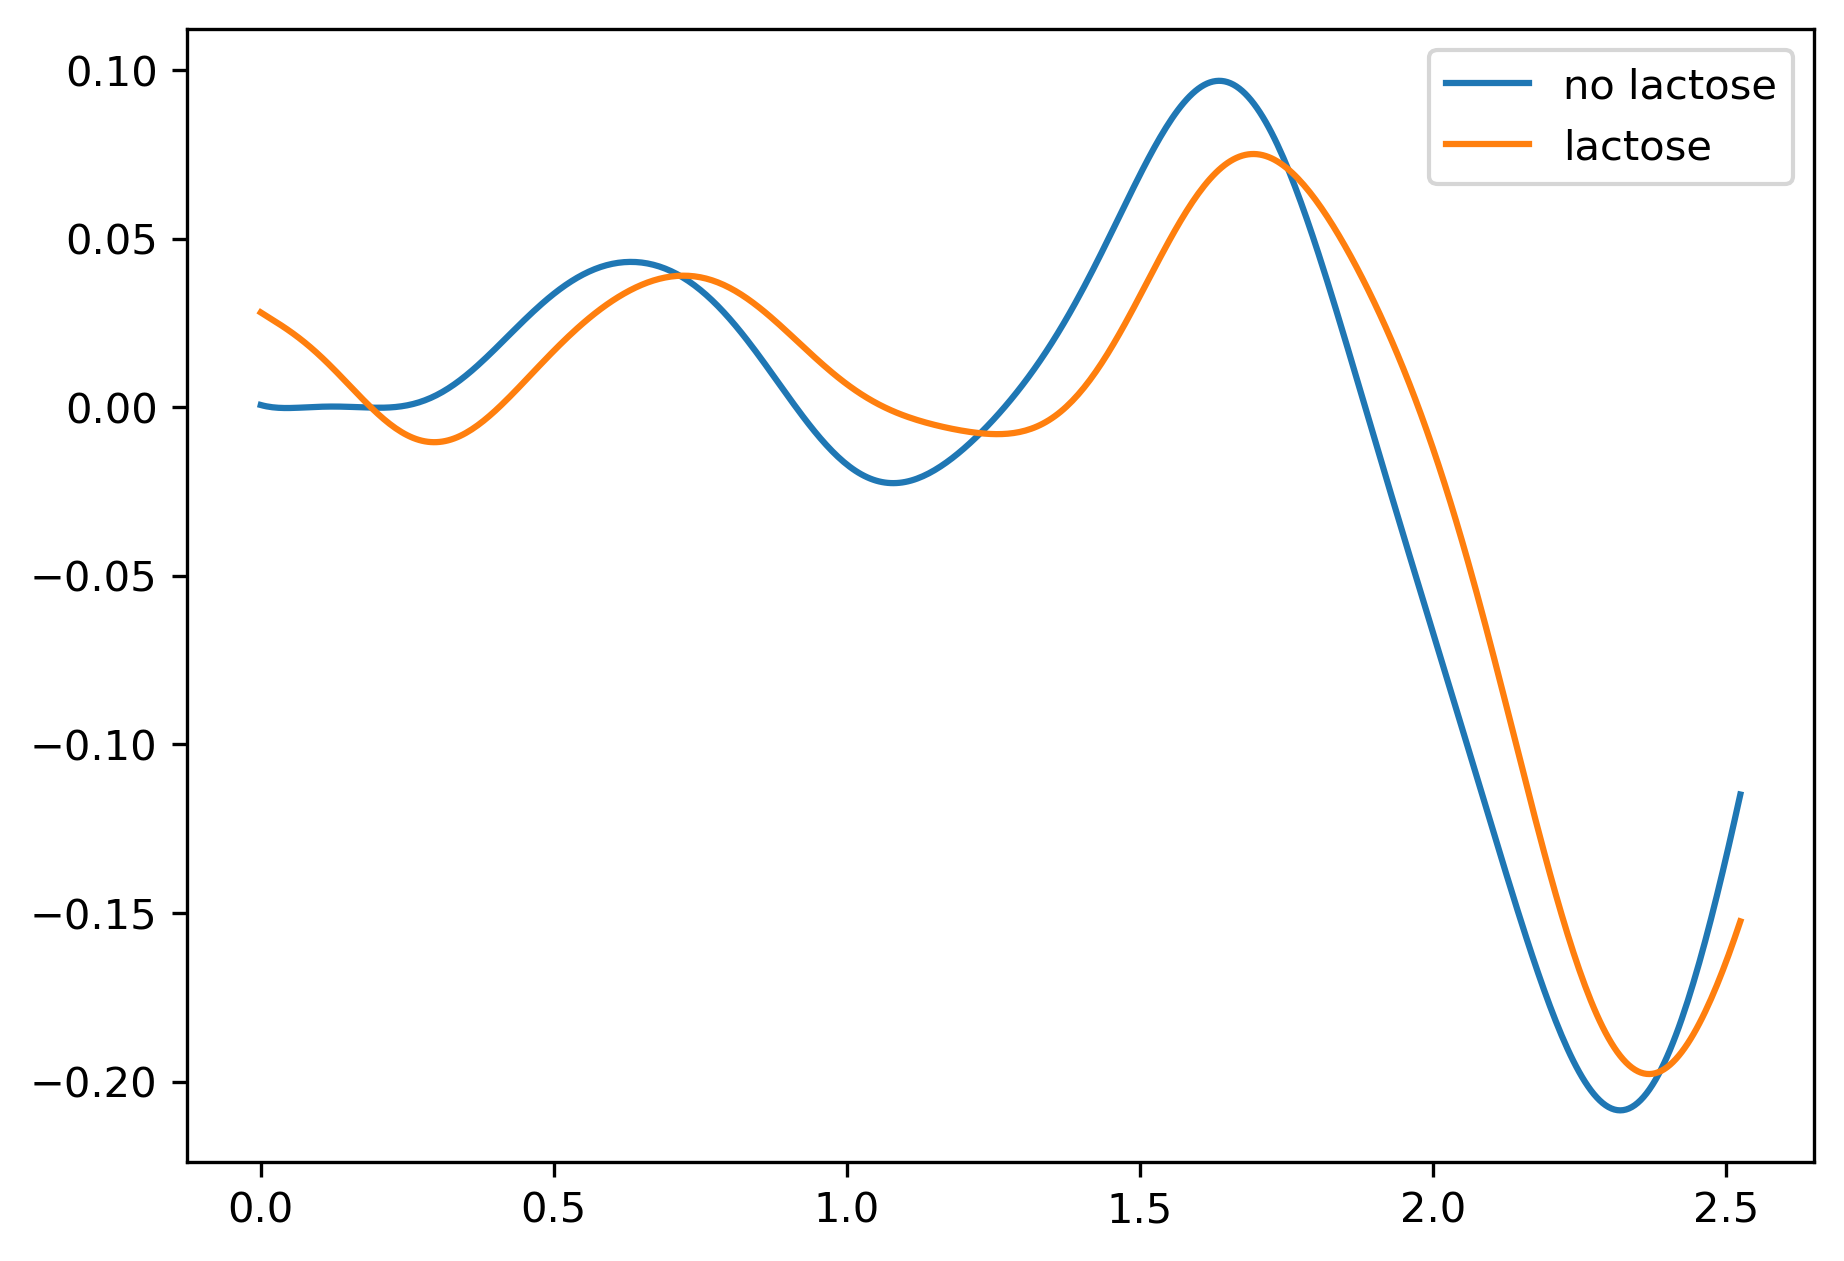

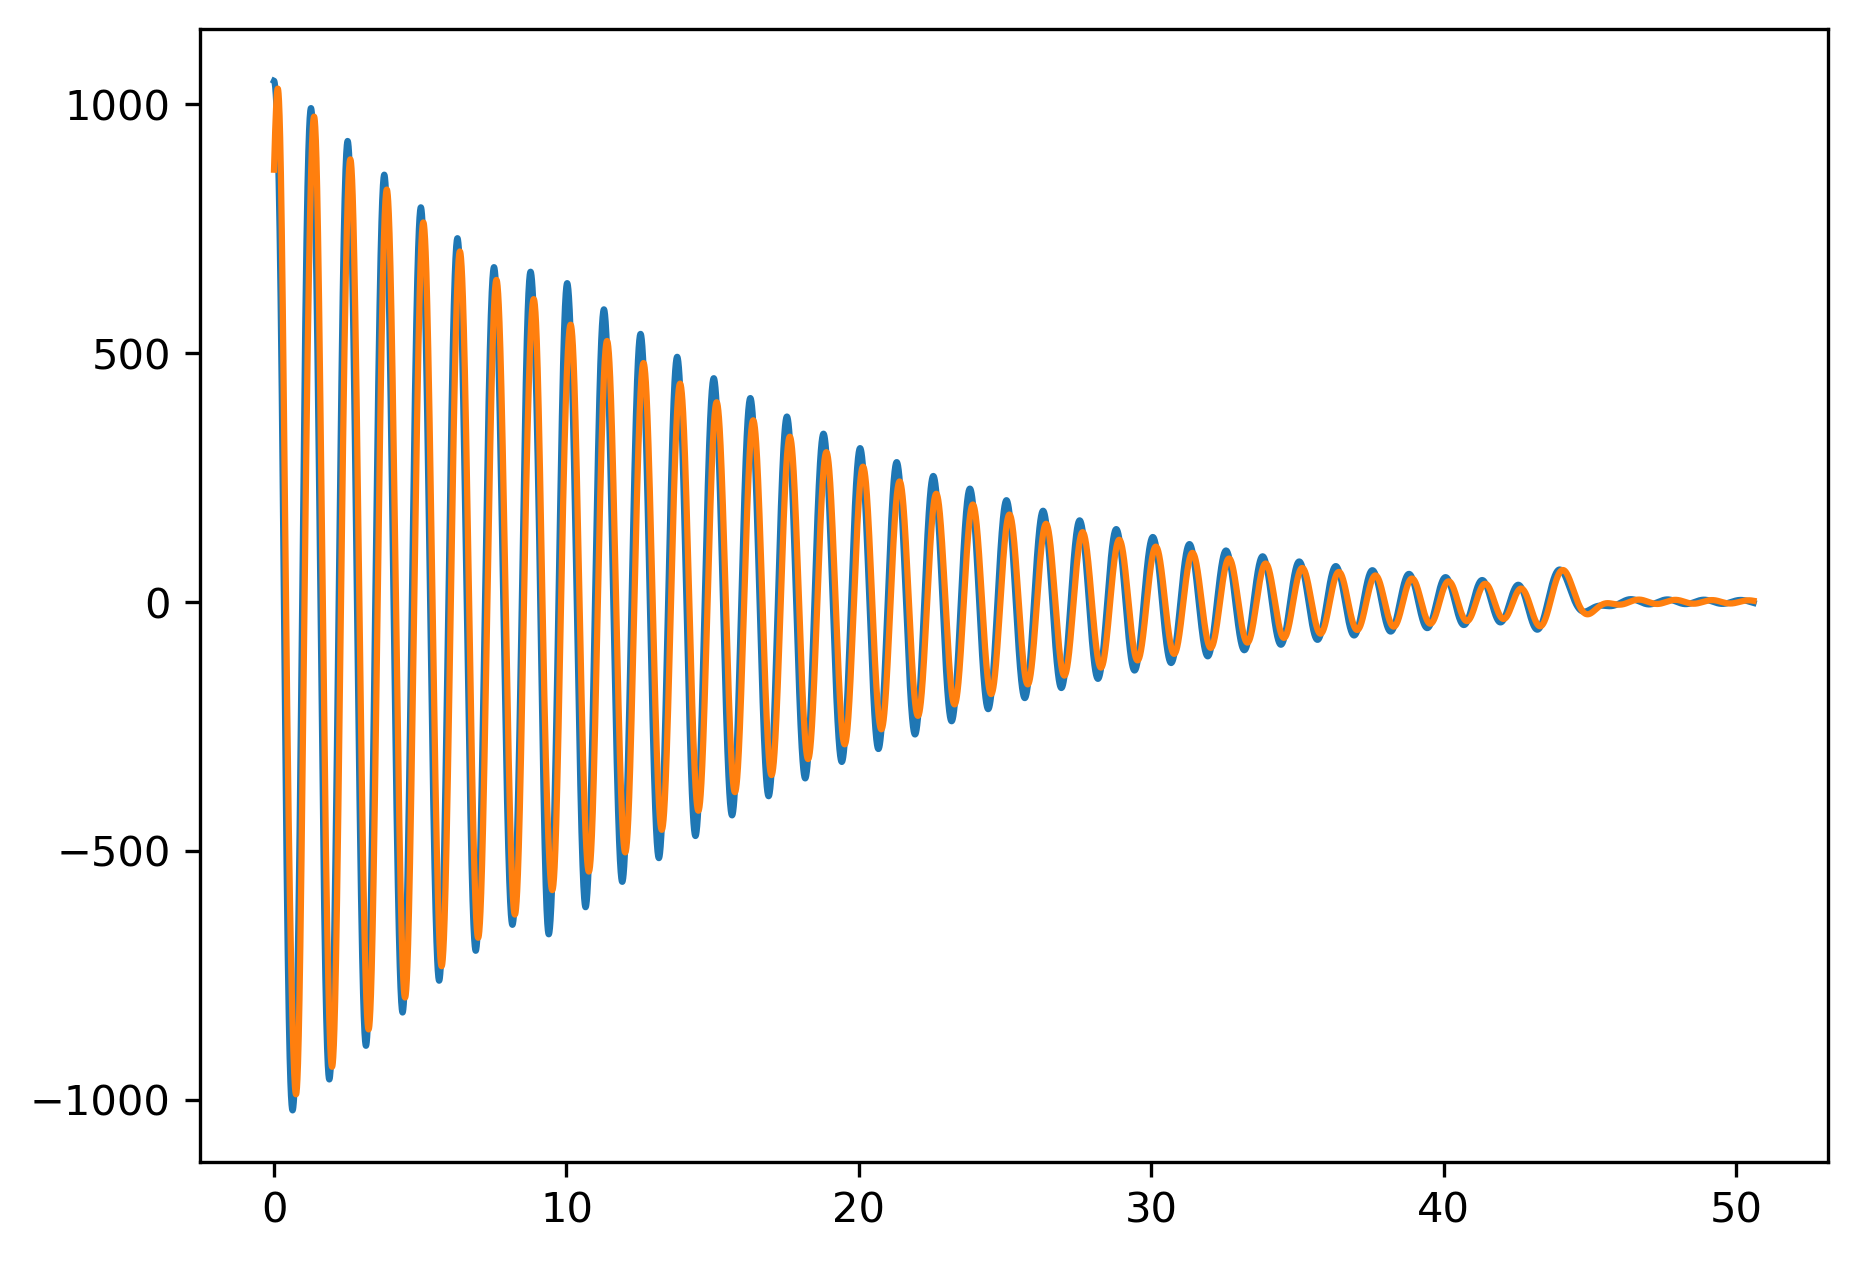

In [15]:
plt.figure(figsize=(7, 5), dpi=300)

no_lactose_field = sample_no_lactose.pulses @ vec
lactose_field = sample_lactose.pulses @ vec

plt.plot(
    sample_no_lactose.times[:2 * observational_window], 
    no_lactose_field[:2 * observational_window].to_numpy(),
    label='no lactose'
)


plt.plot(
    sample_lactose.times[:2 * observational_window], 
    lactose_field[:2 * observational_window].to_numpy(),
    label='lactose'
)

plt.legend()

plt.show()

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(
    sample_no_lactose.times[:40 * observational_window], 
    sample_no_lactose.pulses['f=0.8 THz'][:40 * observational_window].to_numpy(),
    label='no lactose f=0.8 THz'
)

plt.plot(
    sample_lactose.times[:40 * observational_window], 
    sample_lactose.pulses['f=0.8 THz'][:40 * observational_window].to_numpy(),
    label='lactose f=0.8 THz'
)

In [16]:

largest_freq_period = so.observational_window

observational_windows = np.logspace(
    np.log10(0.1 * largest_freq_period), 
    np.log10(15 * largest_freq_period), 
    100,
    dtype=np.int
)

vecs, discriminability = zip(*
    [analyze(_) for _ in observational_windows]
)
discriminability = np.array(discriminability)
vecs = np.array(vecs)

# Specify which eigenvectors to plot 
n = observational_windows.size
vecs_to_plot =  np.array(
     [10, 
      np.searchsorted(observational_windows, largest_freq_period), 
      int(n / 2),
      n-1]
 )


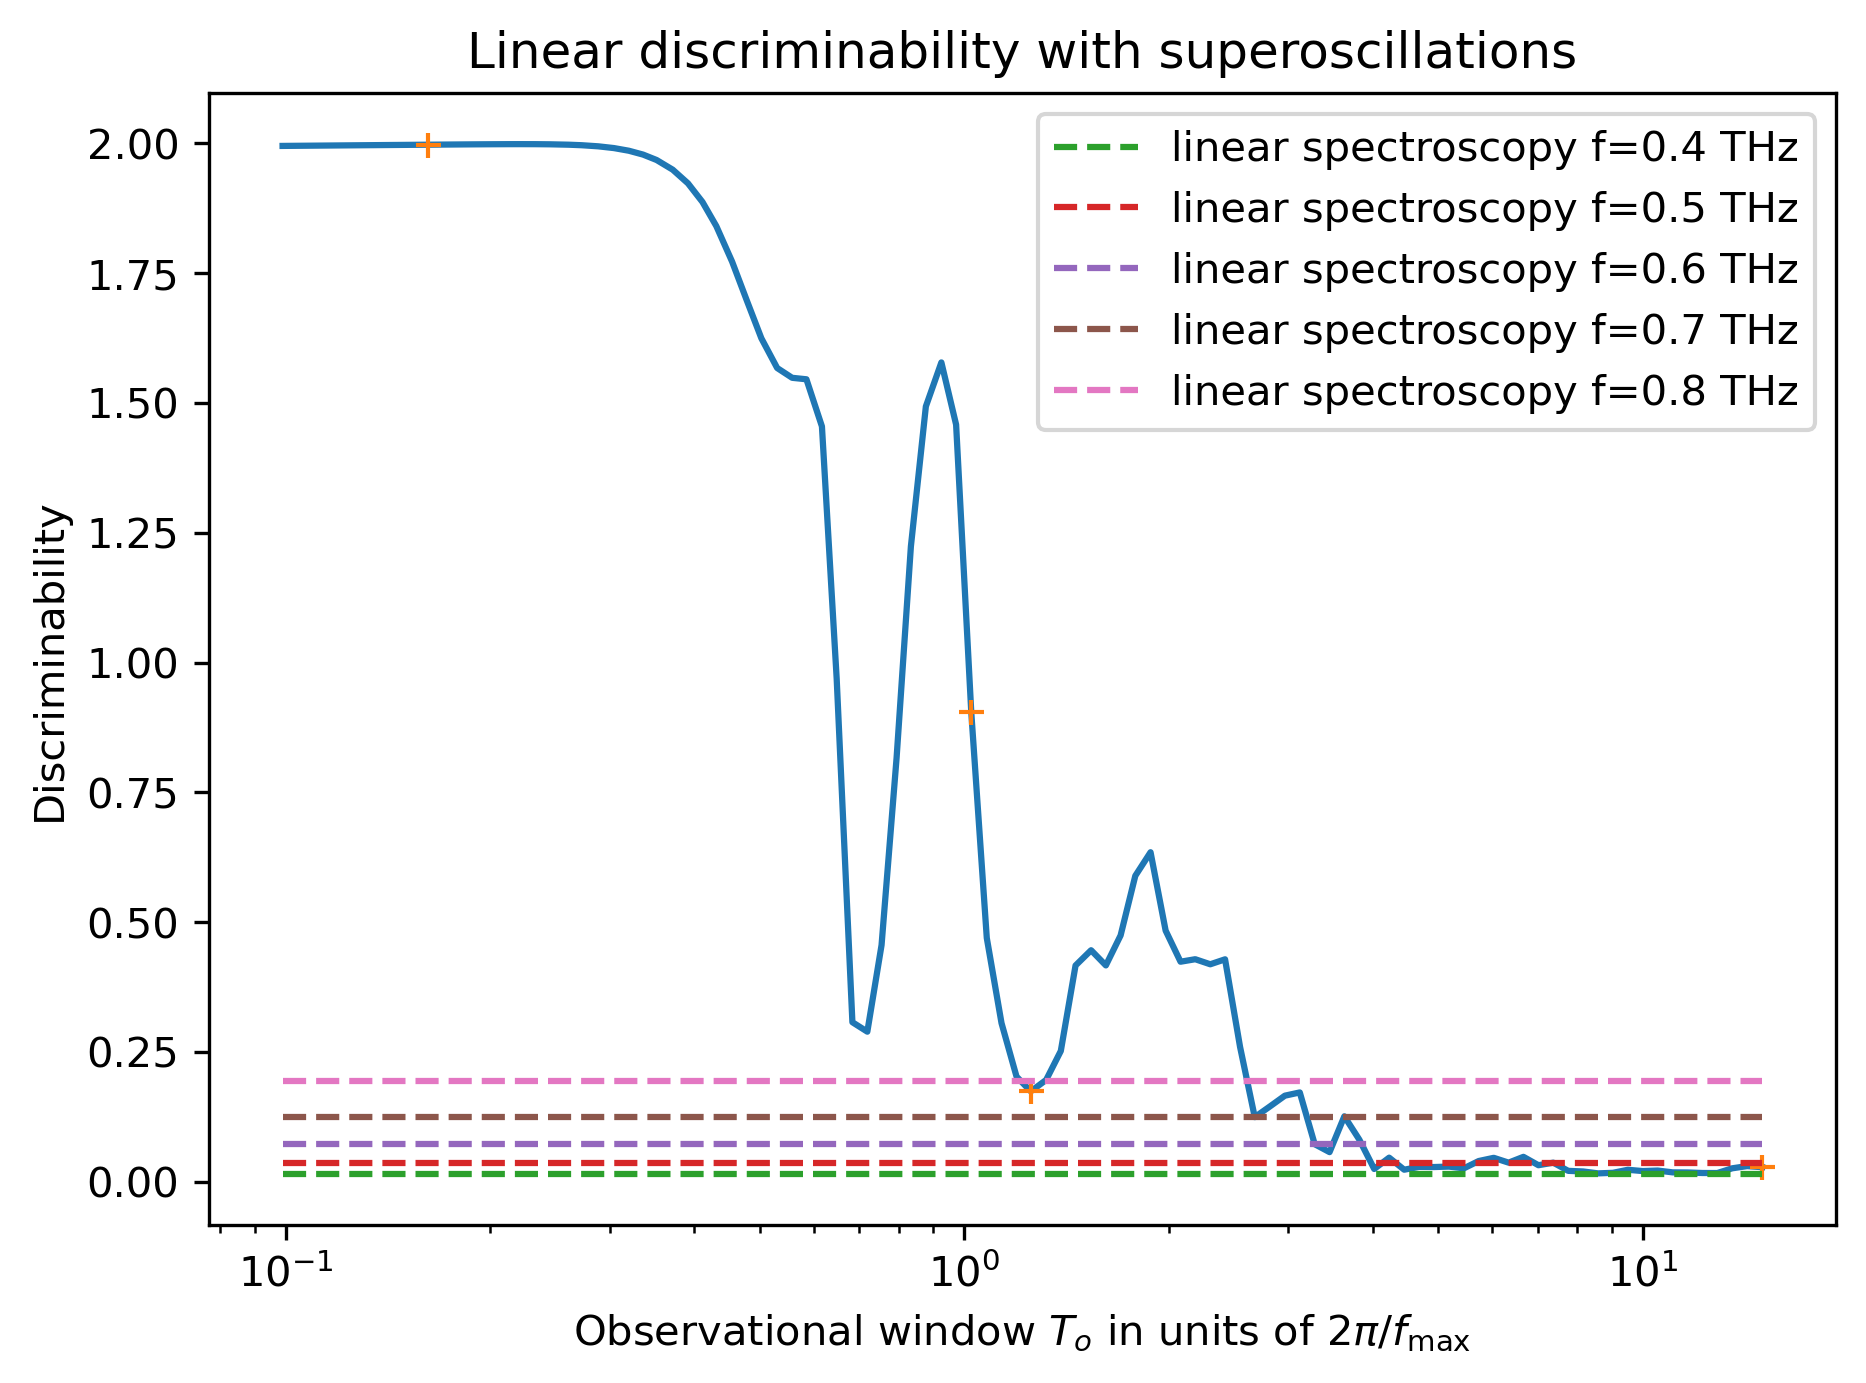

In [17]:
plt.figure(figsize=(7, 5), dpi=300)
plt.title('Linear discriminability with superoscillations')

x = observational_windows / largest_freq_period

plt.semilogx(x, discriminability)

plt.semilogx(
    observational_windows[vecs_to_plot] / largest_freq_period, 
    discriminability[vecs_to_plot],
    '+',
)

# Discriminability if only largest frequencies used
for freq in so.pulses:
    
    linear_spectroscopy_disc = get_discriminability(
        sample_no_lactose.pulses[freq][:pre_pulse_cut_off],
        sample_lactose.pulses[freq][:pre_pulse_cut_off]
    )

    plt.plot(
        [x.min(), x.max()], 
        [linear_spectroscopy_disc, linear_spectroscopy_disc],
        '--',
        label='linear spectroscopy {}'.format(freq)
    )

    
plt.xlabel(r'Observational window $T_o$ in units of $2\pi/f_{\max}$')
#plt.ylabel(r'$\frac{1}{T_0}\int_0^{T_o} (E^{(1)}(t) - E^{(2)}(t))^2 dt$')
plt.ylabel('Discriminability')
plt.legend()

plt.show()

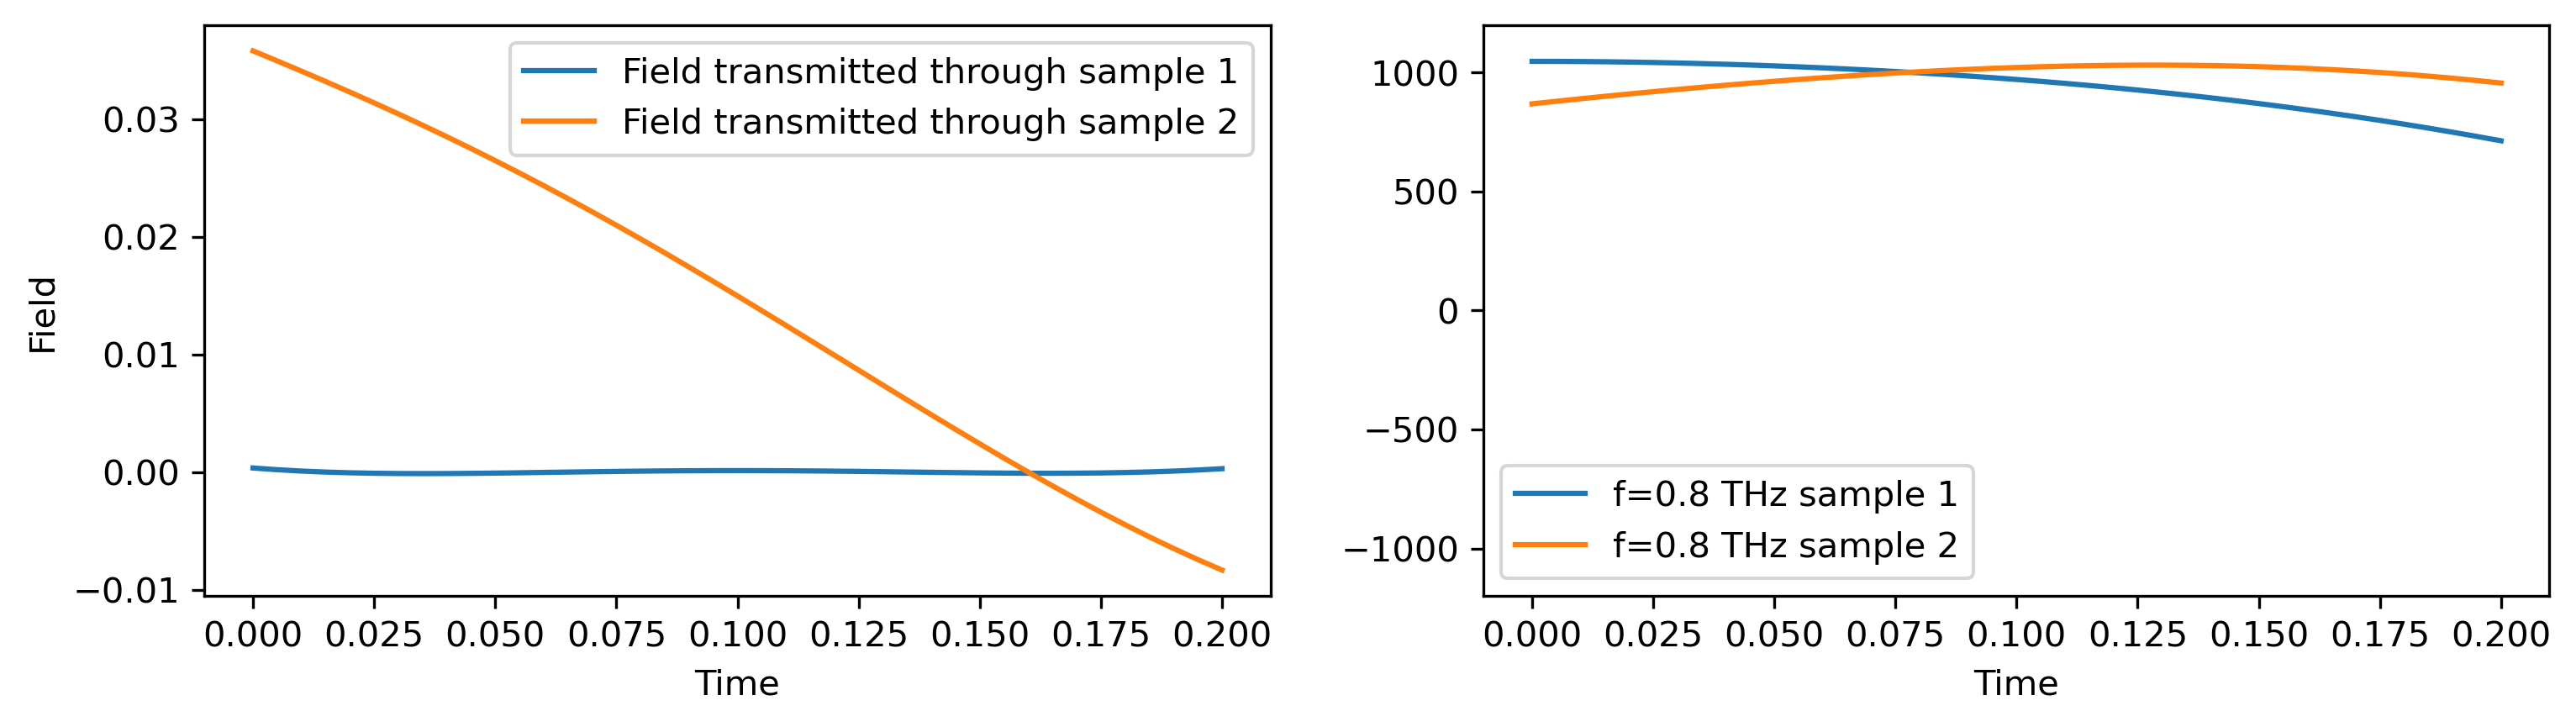

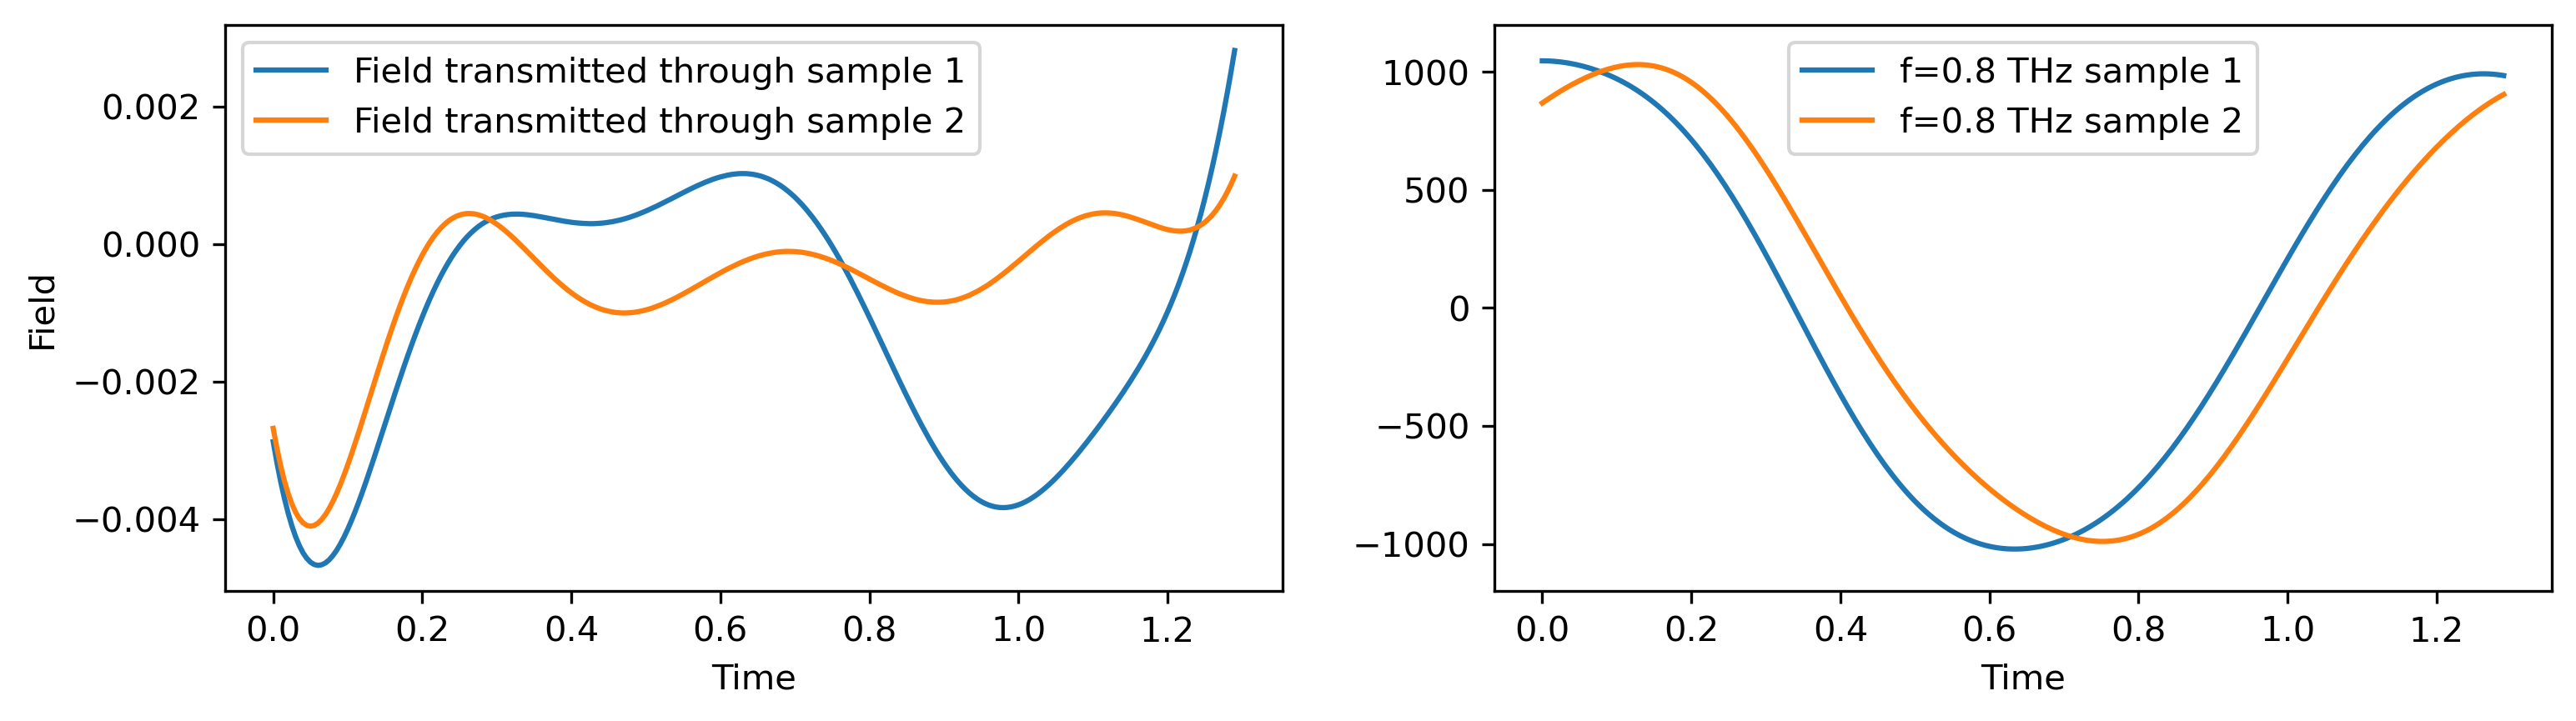

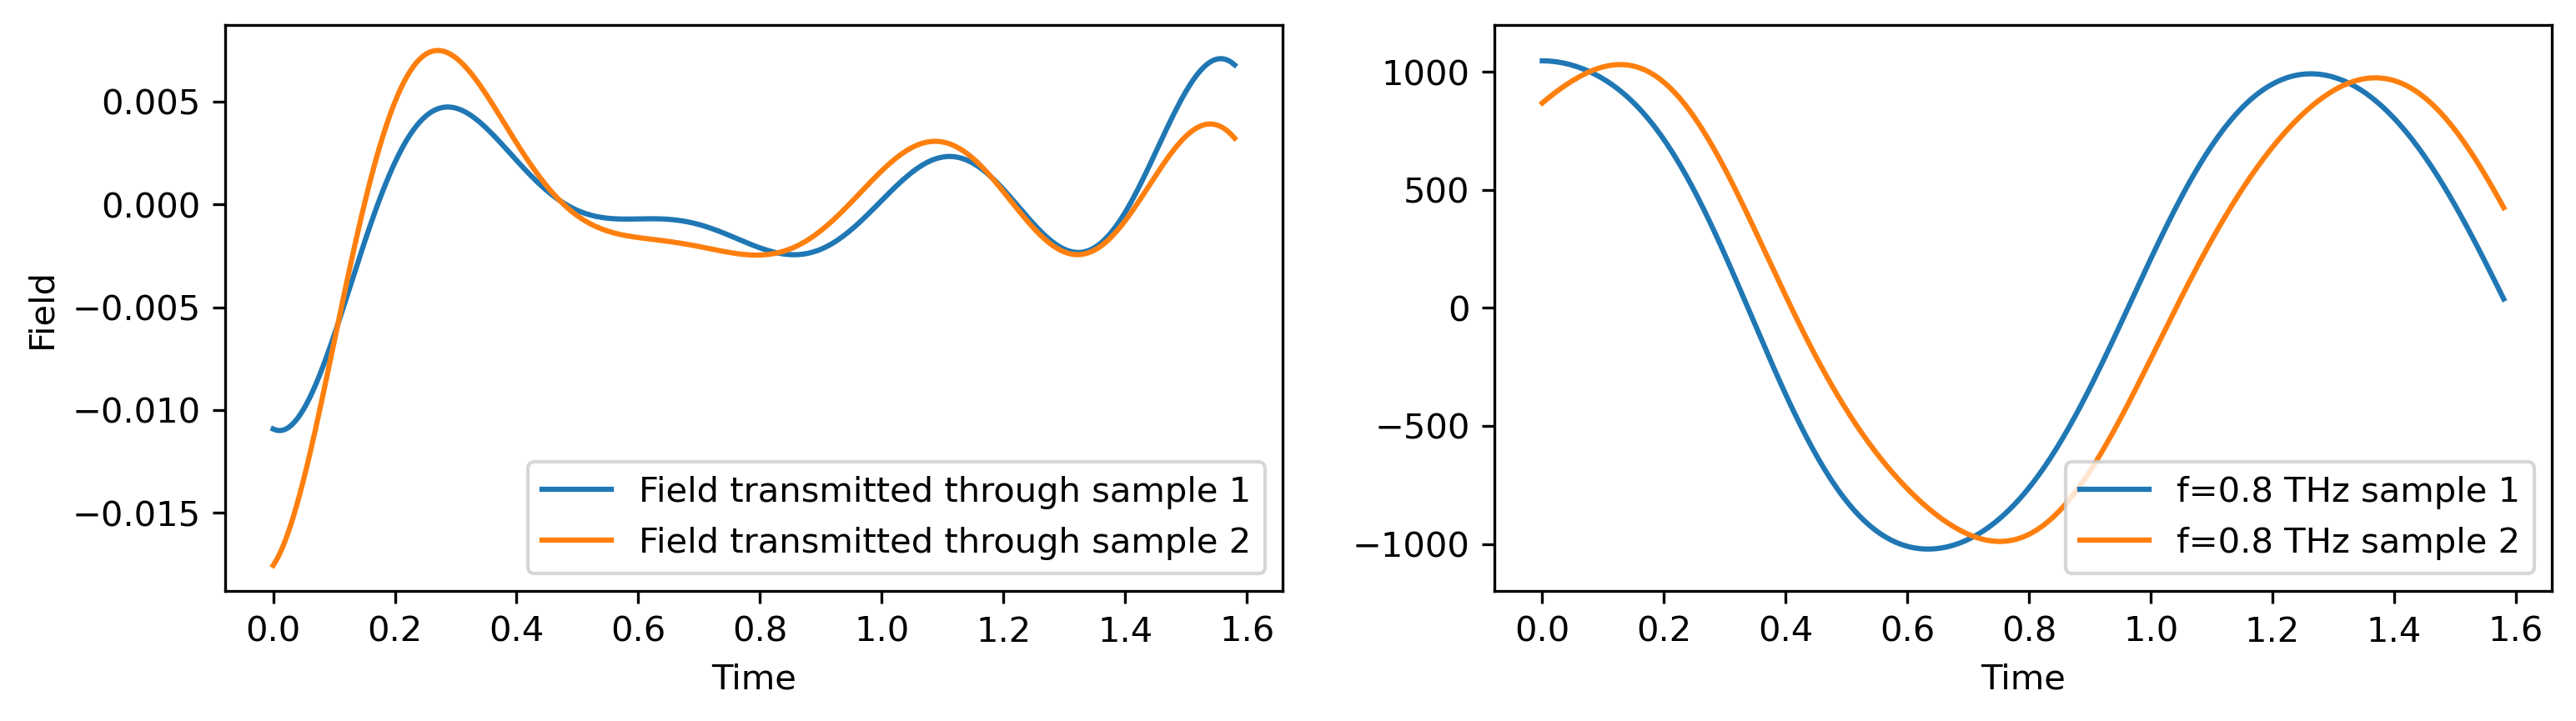

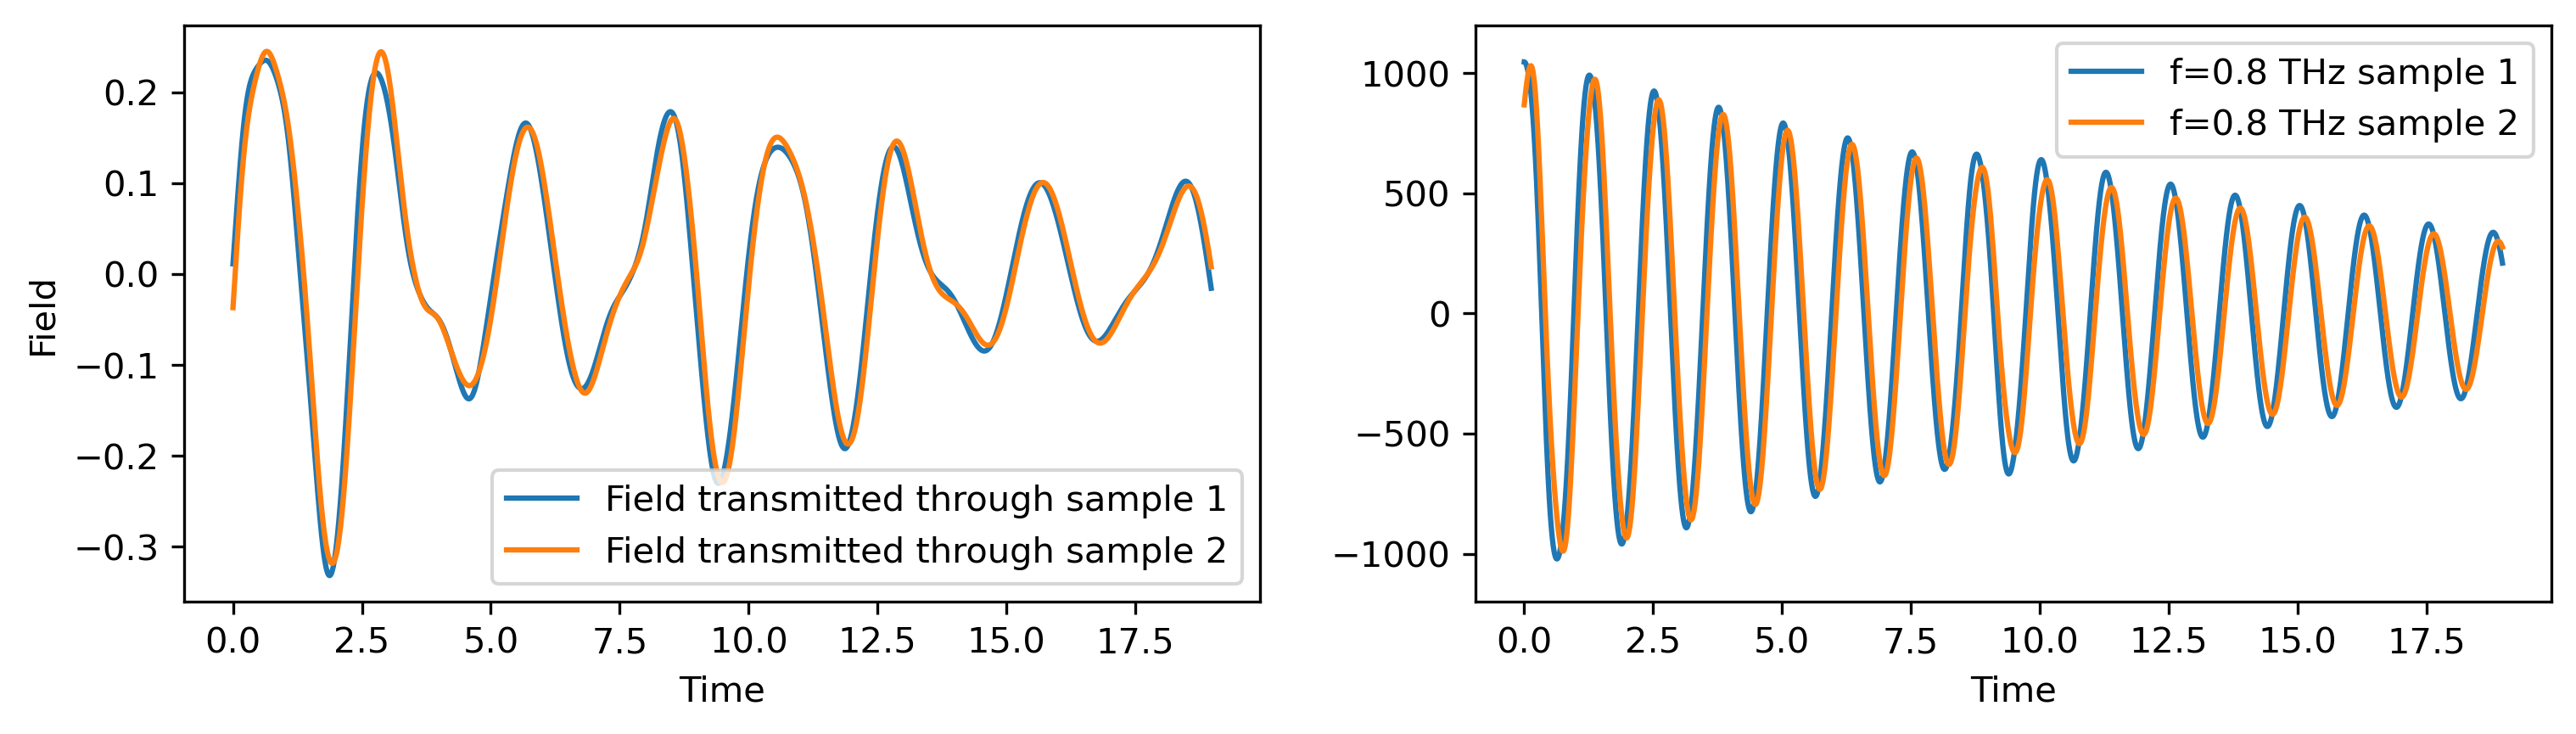

In [18]:
omega = so.omega
largest_freq_pulse = so.pulses[so.largest_freq]

for indx in vecs_to_plot:
    
    vector = vecs[indx].reshape(-1)
    observational_window = observational_windows[indx]
    
    # get superoscilating fields
    field_no_lactose = sample_no_lactose.pulses @ vector
    field_no_lactose = field_no_lactose[:observational_window]
    
    field_lactose = sample_lactose.pulses @ vector
    field_lactose = field_lactose[:observational_window]
    
    # a sanity check
    assert np.allclose(vector.T @ so.S_infty @ vector, 1.)
    
    fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=(12, 3), dpi=300)

    t = times[:observational_window]
    ax1.plot(t, field_no_lactose, label='Field transmitted through sample 1')
    ax1.plot(t, field_lactose, label='Field transmitted through sample 2')
    ax1.legend()
    ax1.set_ylabel('Field')
    ax1.set_xlabel('Time')
    
    
    ax2.plot(
        t, 
        sample_no_lactose.pulses[so.largest_freq][:observational_window],
        label='{} sample 1'.format(so.largest_freq)
    )
    ax2.plot(
        t, 
        sample_lactose.pulses[so.largest_freq][:observational_window],
        label='{} sample 2'.format(so.largest_freq)
    )
    ax2.set_ylim([-1200, 1200])
    ax1.set_ylabel('Field')
    ax2.set_xlabel('Time')
    ax2.legend()
    
    plt.show()